In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
import torch
from utils import MNIST, CIFAR10

train_set = MNIST()
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dimensions = train_set[0].shape
img_size = torch.prod(torch.tensor(dimensions))

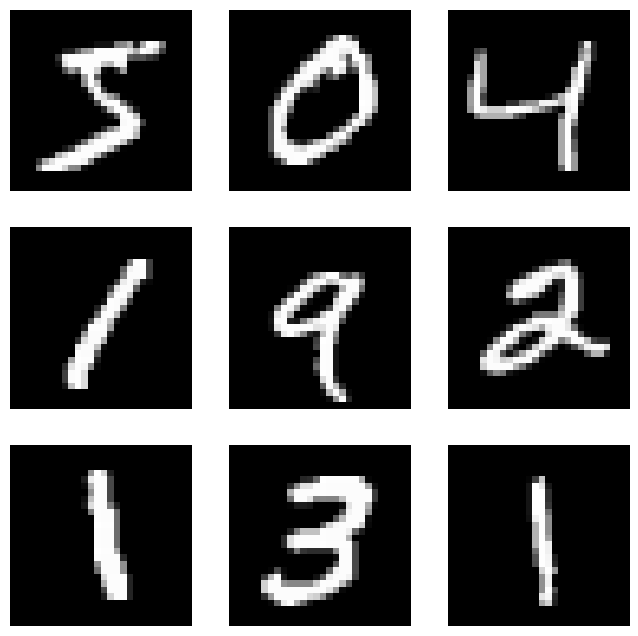

In [2]:
## Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# show multiple images in a 
# grid format
fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(9):
    img = train_set[i]
    img = img * 0.5 + 0.5
    axs[i//3, i%3].imshow(img.view(*dimensions).permute(1,2,0), cmap='gray')
    axs[i//3, i%3].axis('off')


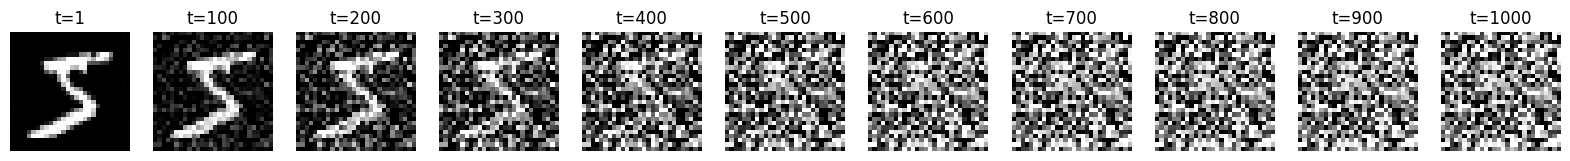

In [3]:
## make noisy images

from utils import NoiseSchedule

beta_start = 1e-4
beta_end = 0.02
T = 500
noise_schedule = NoiseSchedule(beta_start, beta_end, T)

fig, axs = plt.subplots(1, 11, figsize=(20, 2))
x0 = train_set[0].flatten()
ts = torch.linspace(0, T - 1, 11).view(-1, 1).long()
xts, _, _ = noise_schedule.make_noisy_images(x0, ts)
for i, t in enumerate(ts):
    img = xts[i].view(*dimensions).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f't={t.item() + 1}')
plt.savefig("figures/noisy_images.png", dpi=300, bbox_inches='tight')
plt.show()


A better way of understanding the noise scheduling is to examine what happens to the value of a single pixel.
As seen below, the value of the pixel is approching 0 and the standard deviation is approaching 1. In other words, the pixel is becoming closer to a standard normal distribution. This is the goal of the noise scheduling. 
However, the distribution only approaches the standard normal distribution, it does not reach it. This is because the noise is not added to the pixel, but rather multiplied by the pixel. This means that the pixel will never reach 0, but rather approach it. The values of $\mu$ and $\sigma$ for each pixel distribution are shown below.

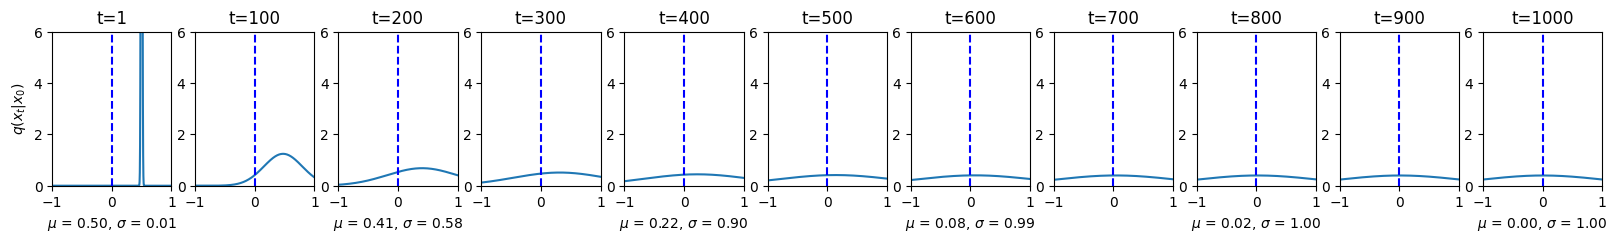

In [4]:
def normal_dist(x, mu, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * std**2))
pixel_value = 0.5
fig, axs = plt.subplots(1, 11, figsize=(20, 2))
mus = noise_schedule.sqrt_alpha_hat[ts]
stds = noise_schedule.sqrt_one_minus_alpha_hat[ts]
xx = torch.linspace(-2, 2, 1000)
for i, t in enumerate(ts):
    mu = mus[i] * pixel_value
    std = stds[i]
    axs[i].plot(xx, normal_dist(xx, mu, std))
    axs[i].set_title(f't={t.item() + 1}')
    axs[i].set_ylim(0, 6)
    axs[i].set_xlim(-1, 1)
    axs[i].axvline(0, color='b', linestyle='--')
    if i % 2 == 0:
        axs[i].set_xlabel("$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(round(mu.item(), 2), round(std.item(), 2)))
    if i == 0:
        axs[i].set_ylabel('$q(x_t | x_0)$')

plt.savefig("figures/pixel_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

To show that the distribution of the final layer actually approaches a standard normal distribution, we've plotted the KL-divergence between each layer and a standard normal. The KL-divergence clearly approaches 0. 

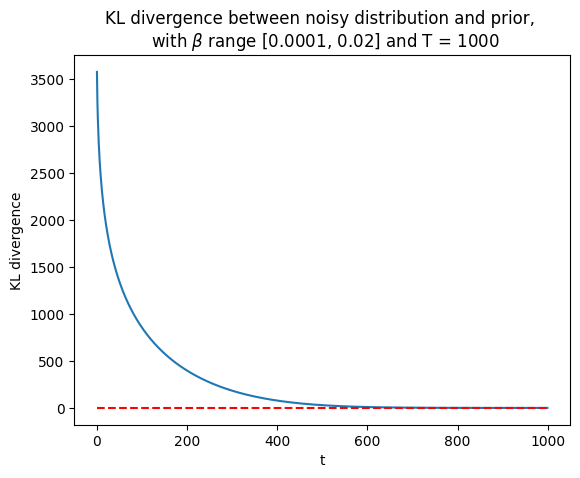

In [5]:
from tqdm import tqdm

## this small image is just a 10x10 patch of the original image

KL_list = np.zeros(T)
for t in range(T):
    mu = noise_schedule.sqrt_alpha_hat[t] * x0.flatten()
    std = noise_schedule.sqrt_one_minus_alpha_hat[t]

    k1 = img_size * std ** 2
    k2 = torch.sum(mu ** 2)
    k3 = - 2 * img_size * torch.log(std)
    kl = 1/2 * (k1 + k2 + k3 - img_size)
    
    KL_list[t] = kl.detach().numpy()

plt.plot(KL_list)
txt = "KL divergence between noisy distribution and prior, \n with " + r"$\beta$" + " range [0.0001, 0.02] and T = {}"
plt.title(txt.format(T))
plt.xlabel("t")
plt.ylabel("KL divergence")
plt.hlines(0, 0, T, color='r', linestyle='--')
plt.show()


We somehow have to encode the different timesteps. Here, we'll use sinusoidal encoding. 


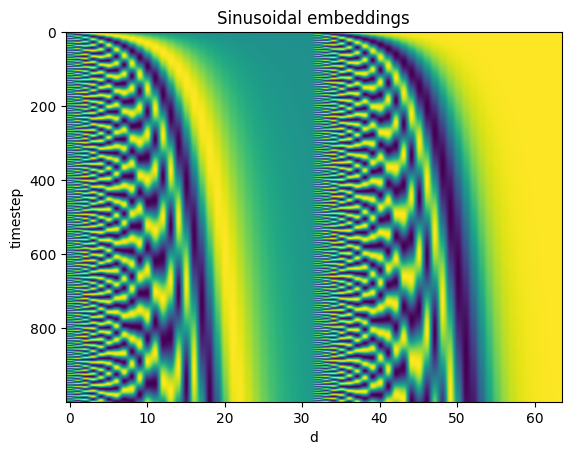

In [6]:
from utils import SinusoidalEmbeddings

ts = np.arange(0, T)
embeddings = SinusoidalEmbeddings(torch.tensor(ts).float())
plt.imshow(embeddings, cmap='viridis', aspect='auto')
plt.ylabel("timestep")
plt.xlabel("d")
plt.title("Sinusoidal embeddings")
plt.savefig("figures/sinusoidal_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
from utils import SimpleModel, ResNET
import torch.nn as nn
mse = nn.MSELoss()

simple_network = ResNET(dimensions[0]).to(device)
args = [simple_network, train_loader, noise_schedule, dimensions, device]
simple_model = SimpleModel(*args)
simple_model.load_model()

Failed to load model from models/simple_model.pt
Initializing new model


In [11]:
def sample_and_show_image(model, title="Sampled image"):
    xt = model.sample()
    xt = (xt - xt.min()) / (xt.max() - xt.min())
    img = xt.view(*dimensions).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [9]:
def training_loop(model, epochs):
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        losses = torch.zeros(len(train_loader))

        for i, x0 in enumerate(tqdm(train_loader)):
            loss = model.loss(x0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i] = loss.item()

        print(f"Epoch: {epoch}")
        print(losses.mean().item())
        sample_and_show_image(model, "Epoch {}".format(epoch))
        model.save_model()

100%|██████████| 937/937 [18:45<00:00,  1.20s/it]


Epoch: 0
0.046544644981622696
Sampling image..


100%|██████████| 999/999 [00:26<00:00, 38.22it/s]


Done sampling image


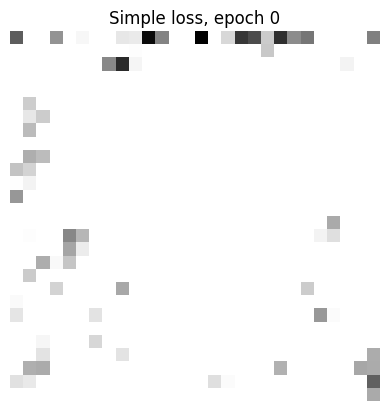

Model saved to models/simple_model.pt


100%|██████████| 937/937 [18:43<00:00,  1.20s/it]


Epoch: 1
0.02917269989848137
Sampling image..


100%|██████████| 999/999 [00:26<00:00, 37.75it/s]

Done sampling image


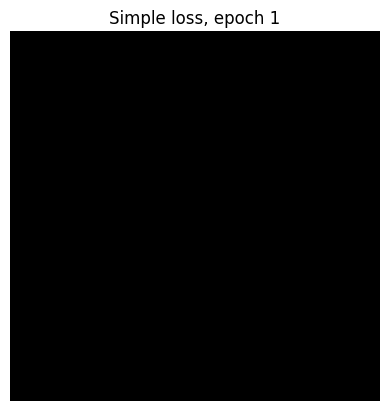

Model saved to models/simple_model.pt


100%|██████████| 937/937 [18:37<00:00,  1.19s/it]


Epoch: 2
0.02781568467617035
Sampling image..


100%|██████████| 999/999 [00:26<00:00, 37.54it/s]


Done sampling image


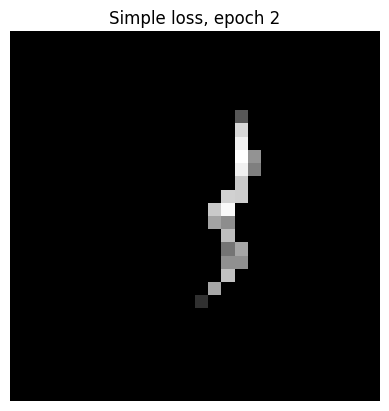

Model saved to models/simple_model.pt


  0%|          | 3/937 [00:06<31:54,  2.05s/it]


KeyboardInterrupt: 

In [10]:
training_loop(simple_model, 10)

Failed to load model from mu_model.pt
Initializing new model


100%|██████████| 78/78 [01:42<00:00,  1.32s/it]


Epoch: 0
0.06451169401407242
Sampling image..


100%|██████████| 999/999 [00:26<00:00, 37.51it/s]


Done sampling image


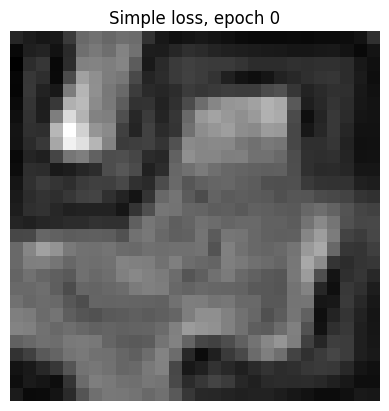

Model saved to models/simple_loss.pt


100%|██████████| 78/78 [01:41<00:00,  1.30s/it]


Epoch: 1
0.018236303701996803
Sampling image..


100%|██████████| 999/999 [00:27<00:00, 36.50it/s]


Done sampling image


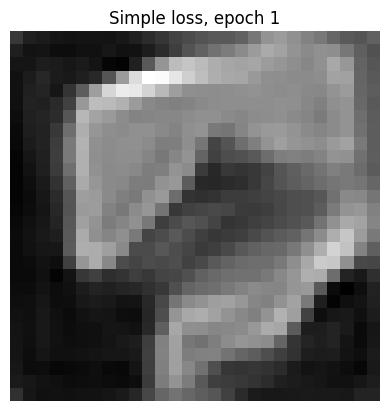

Model saved to models/simple_loss.pt


100%|██████████| 78/78 [01:40<00:00,  1.29s/it]


Epoch: 2
0.01505712978541851
Sampling image..


100%|██████████| 999/999 [00:26<00:00, 37.56it/s]


Done sampling image


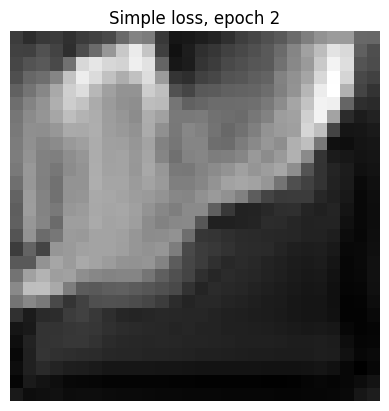

Model saved to models/simple_loss.pt


 28%|██▊       | 22/78 [00:29<01:15,  1.35s/it]


KeyboardInterrupt: 

In [10]:
from utils import MuModel
mu_network = ResNET(dimensions[0]).to(device)
args = [mu_network, train_loader, noise_schedule, dimensions, device]
mu_model = MuModel(*args)
mu_model.load_model()

training_loop(mu_model, 10)